# Table of Contents
- [Overview](#overview)
- [Setup](#setup)
- [Package installs](#package-installs)
- [Authentication and Google Cloud settings](#authentication-and-google-cloud-settings)
- [Imports](#imports)
- [Global variables](#global-variables)
- [Utils](#utils)
- [Updating searchable and retrievable fields](#updating-searchable-and-retrievable-fields)
- [Advanced search configurations](#advanced-search-configurations)
  - [1. Simple Search Query](#1-simple-search-query)
  - [2. Faceted Search](#2-faceted-search)
  - [3. Query Expansion](#3-query-expansion)
  - [4. Pagination](#4-pagination)
  - [5. Ordering Results](#5-ordering-results)
  - [6. Filtering Results](#6-filtering-results)
  - [7. Boosting Results](#7-boosting-results)

# Overview
This lab will demonstrate how to configure and use the Google Cloud Retail API for advanced product search and discovery. You will learn how to:

- Inspect and update catalog attribute configurations, including searchable, indexable, and retrievable fields.
- Apply advanced search features such as faceting, filtering, ordering, pagination, query expansion, and result boosting.

By the end of this lab, you will understand how to customize search behavior and optimize product discovery experiences for e-commerce applications using the Google Cloud Retail API.

# Setup
You will get started by preparing your environment. You will begin with authentication and configuration, which are required for all subsequent API calls.

## Package installs
Install all required Python packages. Run this cell only once after starting a new kernel.

In [ ]:
%pip install google google-cloud-retail google-cloud-storage google-cloud-bigquery pandas
%pip install google-cloud-bigquery-storage pyarrow tqdm bigquery-magics
%pip install google-cloud-bigquery[pandas] jupyterlab
%pip install fsspec gcsfs
%pip install matplotlib seaborn plotly
%pip install --upgrade ipython-sql

## Authentication and Google Cloud settings
Before you can interact with the Retail API, you will need to authenticate with Google Cloud and set up your project context. This ensures all API calls are authorized and associated with the correct Google Cloud project. If authentication fails, you will be prompted to log in interactively. The `project_id` variable will be used throughout the notebook.

**About `project_id` and Application Default Credentials (ADC):**

- **`project_id`**: This uniquely identifies your Google Cloud project. All API requests, resource creation, and billing are tied to this project. Setting the correct `project_id` ensures your operations are performed in the intended environment and resources are properly tracked.

- **Application Default Credentials (ADC)**: Application Default Credentials is a mechanism that allows your code to automatically find and use your Google Cloud credentials. Running the `gcloud auth application-default login` command sets up Application Default Credentials by generating credentials that client libraries (like the Retail API) can use to authenticate API calls on your behalf.

**Why this matters:**  
Proper authentication and project selection are essential for secure, authorized access to Google Cloud resources. Without these, API calls will fail or may affect the wrong project. Application Default Credentials simplifies credential management, especially in development and notebook environments.

In [ ]:
import subprocess

try:
  # Try to get an access token
  subprocess.check_output(
    ['gcloud', 'auth', 'application-default', 'print-access-token'],
    stderr=subprocess.STDOUT
  )
  print("Already authenticated with Application Default Credentials.")
except subprocess.CalledProcessError:
  # If it fails, prompt for login
  print("No valid ADC found. Running interactive login...")
  !gcloud auth application-default login

## Imports
Import all necessary libraries for API access, data analysis, and visualization.

In [ ]:
from google.cloud.retail_v2 import SearchServiceClient, ProductServiceClient, PredictionServiceClient
from google.cloud.retail_v2.types import product, search_service, ListProductsRequest, SearchRequest, PredictRequest, UserEvent
from google.protobuf.field_mask_pb2 import FieldMask
from google.protobuf.json_format import MessageToDict
import pandas as pd
import http.client as http_client
import logging
import re
from IPython.display import display_html
from matplotlib import pyplot as plt
import seaborn as sns

# enabling BigQuery magics
%load_ext bigquery_magics

# configuring default optoins for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Global variables
With authentication complete, you will define some key variables that will be used in all your API calls. These include resource names and placements, which specify the context for search and recommendation requests.

**What is a 'placement'?**  
A placement is a configuration resource in the Retail API that determines how and where a model is used for serving search or recommendation results. Placements define the context (such as search, browse, or recommendation) and can be customized for different pages or user experiences.

**Why might you have multiple placements or branches?**  
- You may have different placements for various parts of your site or app, such as a homepage recommendation carousel, a category browse page, or a personalized search bar.
- Multiple branches allow you to manage different versions of your product catalog (e.g., staging vs. production, or A/B testing different product sets).

**Example scenarios:**
- Using a "default_search" placement for general product search, and a "recently_viewed_default" placement for showing users their recently viewed items.
- Having separate branches for testing new product data before rolling it out to all users, or for running experiments with different recommendation models.

In [ ]:
import google.auth
import google.auth.exceptions

# Authenticate with Google Cloud and get the default project ID
try:
  credentials, project_id = google.auth.default()
  print(f"Using project ID: {project_id}")
except google.auth.exceptions.DefaultCredentialsError:
  print("Google Cloud Authentication failed. Please configure your credentials.")
  print("You might need to run 'gcloud auth application-default login'")
  project_id = None # Set to None or a default
  
  
# Define the default placement for search and recommendations
DEFAULT_SEARCH = (
  f"projects/{project_id}/locations/global/catalogs/default_catalog/"
  "placements/default_search" # Use default_search unless you have a specific browse placement
)

RECENTLY_VIEWED_DEFAULT = (
  f"projects/{project_id}/locations/global/catalogs/default_catalog/"
  "placements/recently_viewed_default"
)

DEFAULT_BRANCH = f"projects/{project_id}/locations/global/catalogs/default_catalog/branches/1"

Note that in this lab you will use Branch1 for all your API calls. It has been preloaded with smaller datasets to allow for faster execution and easier debugging. In a production environment, you would typically use the main branch (often called "default") for serving live traffic.

## Utils
To make your analysis easier, you will use some utility functions for data conversion and HTTP logging. These will help you convert API responses to Pandas DataFrames for analysis and enable detailed logging for troubleshooting.

In [ ]:
import pandas as pd
from google.protobuf.json_format import MessageToDict

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def json2df(products_list):
  if products_list:
    products_dicts = [dict(sorted(MessageToDict(p._pb).items())) for p in products_list]
    df = pd.json_normalize(products_dicts)
    return df
  else:
    print("No products returned or an error occurred.")
    return pd.DataFrame()

from contextlib import contextmanager

@contextmanager
def http_logging(log_http: bool):
    """
    Context manager to enable/disable HTTP logging for Google API clients.
    Usage:
        with http_logging(log_http):
            # code that needs HTTP logging
    """
    import http.client as http_client
    import logging
    root_logger = logging.getLogger()
    original_http_debuglevel = http_client.HTTPConnection.debuglevel
    original_log_level = root_logger.level
    try:
        if log_http:
            print("\n--- [INFO] Enabling HTTP Logging (forcing REST transport) ---")
            logging.basicConfig()
            root_logger.setLevel(logging.DEBUG)
            http_client.HTTPConnection.debuglevel = 1
            print("--- [INFO] Using REST transport. ---")
        yield
    finally:
        if log_http:
            http_client.HTTPConnection.debuglevel = original_http_debuglevel
            root_logger.setLevel(original_log_level)
            print("--- [INFO] HTTP Logging & Root Log Level Restored ---")

def print_search_results(response):
    print(f"---Total results found: {response.total_size}---")
    for result in response.results:
        print(result)

## Updating searchable and retrievable fields
You will run a simple search query to verify that your setup is working correctly. This will help you ensure that the searchable and retrievable fields are properly configured in your Retail API index.

In [ ]:
from google.cloud.retail_v2 import SearchServiceClient
from google.cloud.retail_v2.types import SearchRequest

search_client = SearchServiceClient()
request = SearchRequest(
  placement=DEFAULT_SEARCH,
  branch=DEFAULT_BRANCH,
  query="Hoodie",
  visitor_id="123456",
  page_size=3
)
response = search_client.search(request)
print(f"Total Results: {response.total_size}:")
for result in response.results:
  print(result)

You should see something like this:

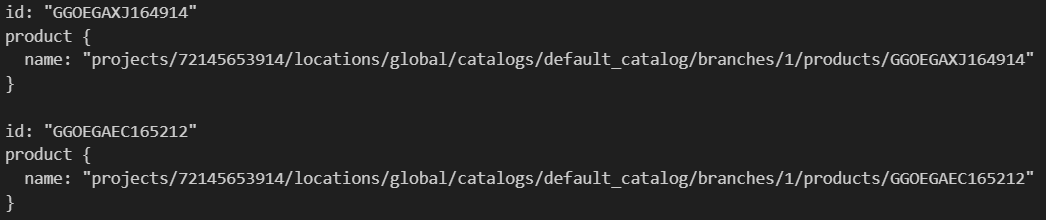

![Basic Results](img/basic_results.png)

Only ID and Product.Name fields are returned. In normal production use, this might be adequate, since you can access the 'source of truth' product catalog and retrieve relevant product details from there. However, for this lab, you will update the searchable and retrievable fields to include more product attributes, such as Product.Description and Product.Categories.



The Retail API allows you to specify which fields in your product catalog are searchable, indexable and retrievable. Attribute configuration settings will impact search and recommendations behavior across your site.

Search uses the following attribute settings:

* **Indexable:** Search can filter and facet using this attribute.
* **Dynamic faceting:** Search can automatically use this attribute as a dynamic facet based on past user behavior such as facet clicks and views. To enable dynamic faceting for an attribute, Indexable must be set to true for that attribute.
* **Searchable:** This attribute is searchable by search queries, which increases recall for that attribute. This control is applicable only for text attributes.
* **Retrievable:** If set to true, search returns this attribute in responses to search queries. If all attributes have Retrievable set to false, the search results contain only the product name or (for variants) the product name and color information.

It is recommended that you retrieve only the fields you need for your application to optimize performance and reduce costs. For the purpose of this lab, you will make all fields searchable and retrievable. This is not recommended for production use, but it will simplify demonstration of the effects some of the advanced search configurations have on the results.

Note that changes to indexable, searchable and retrievable take effect immediately upon your next catalog full ingestion or within 12 hours or more. Changes to dynamic faceting and tiling and exact match take effect within 2 days. Changes to filterable only apply to filter tag generation for recommendations and take effect within 12 hours or more.

Firstly, you will retrieve the current catalog configuration to see which fields are searchable and retrievable. You can also check current settings in the Google Cloud Console: https://console.cloud.google.com/ai/retail/catalogs/default_catalog/controls/site:

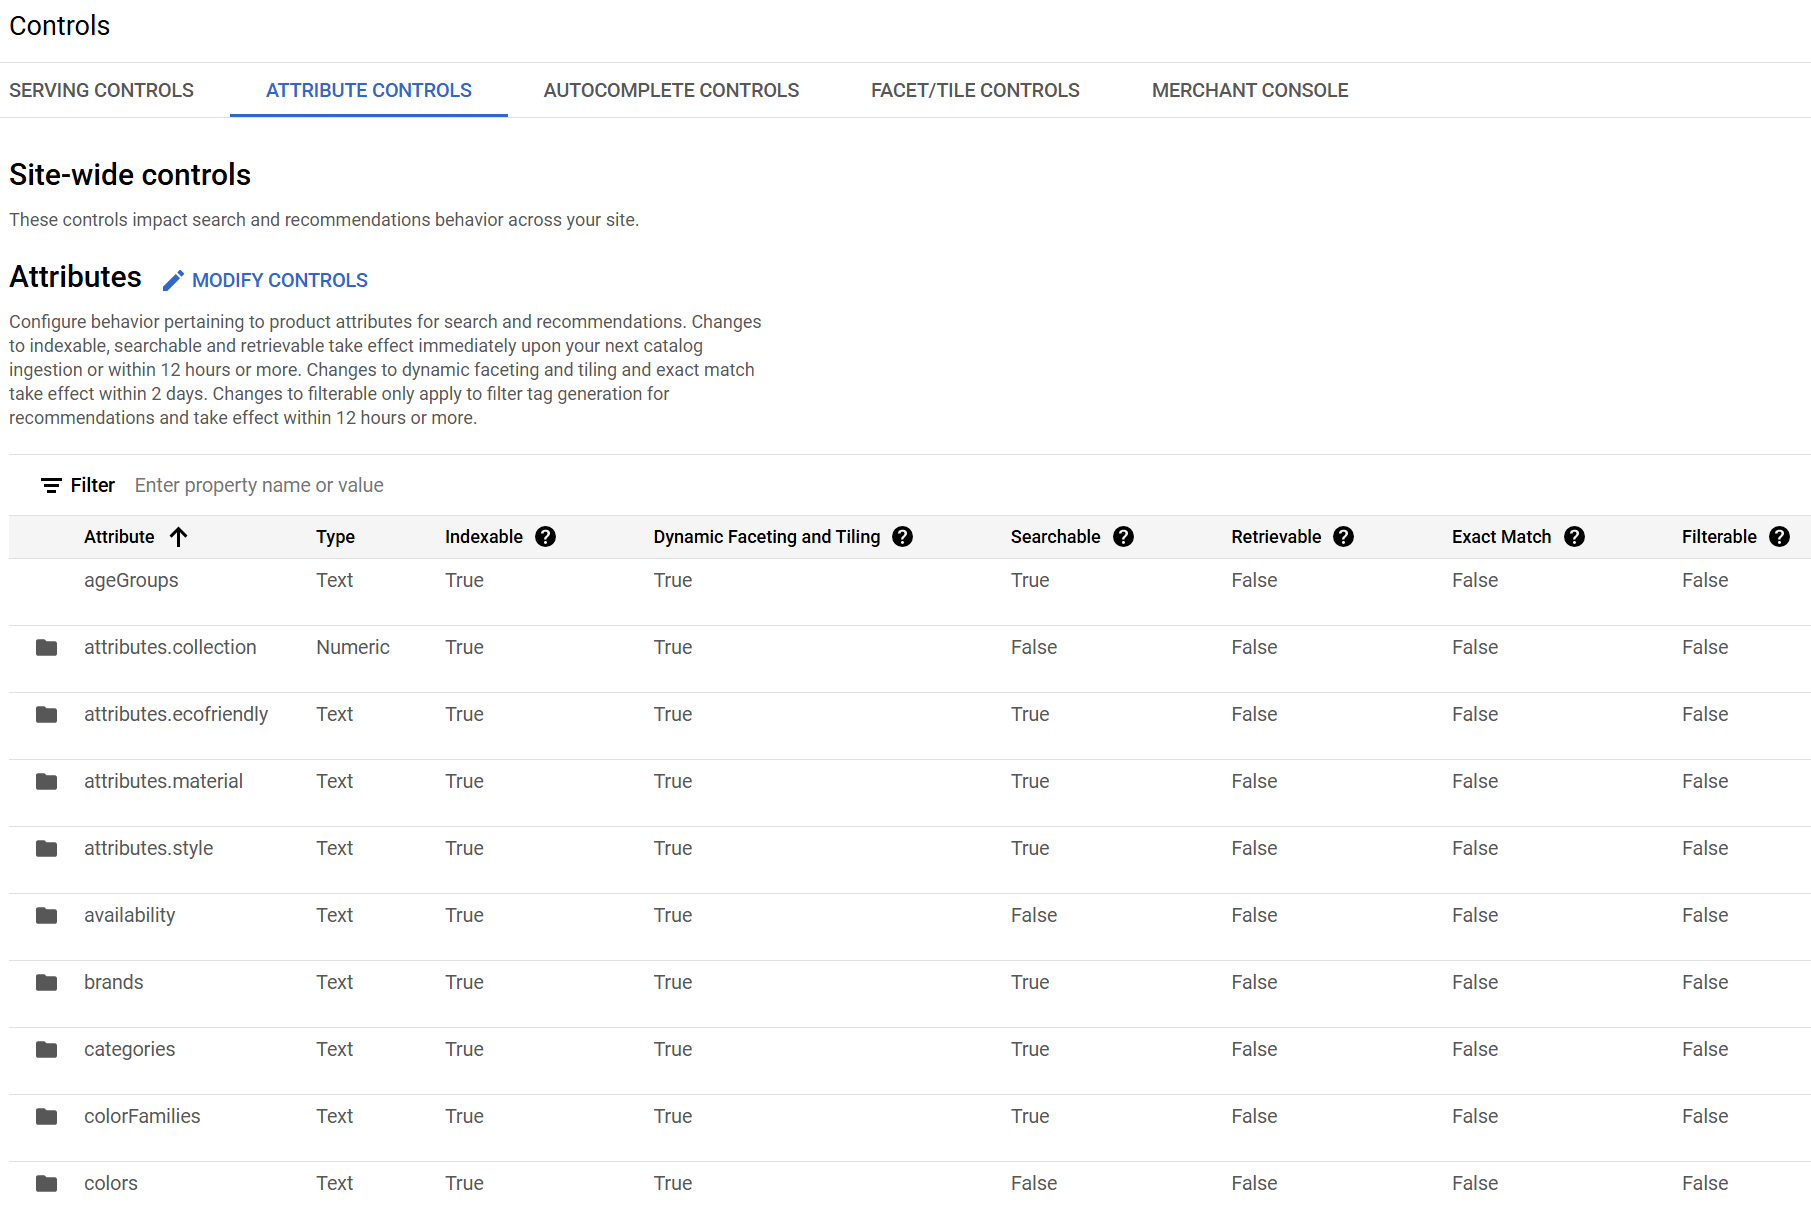

The code below will fetch the catalog configuration and display the searchable and retrievable fields programmatically.

In [ ]:
from google.cloud.retail_v2 import CatalogServiceClient
import pandas as pd

catalog_service_client = CatalogServiceClient()
catalog_name = f"projects/{project_id}/locations/global/catalogs/default_catalog/attributesConfig"
attributes_config = catalog_service_client.get_attributes_config(name=catalog_name)

# Prepare lists to hold attribute info
attribute_names = []
indexable_options = []
searchable_options = []
retrievable_options = []

# Enum values for indexable_option, searchable_option, and retrievable_option:
#   0: OPTION_UNSPECIFIED
#   1: ENABLED (e.g., INDEXABLE_ENABLED, SEARCHABLE_ENABLED, RETRIEVABLE_ENABLED)
#   2: DISABLED (e.g., INDEXABLE_DISABLED, SEARCHABLE_DISABLED, RETRIEVABLE_DISABLED)
# These are stored as strings in the DataFrame, but the underlying proto values are integers.

# Map enum values to readable strings
option_map = {0: 'Unknown', 1: 'True', 2: 'False'}

for attr_name, attr_config in attributes_config.catalog_attributes.items():
    attribute_names.append(attr_name)
    value = attr_config
    indexable_options.append(option_map.get(getattr(value, "indexable_option", 0), 'Unknown'))
    searchable_options.append(option_map.get(getattr(value, "searchable_option", 0), 'Unknown'))
    retrievable_options.append(option_map.get(getattr(value, "retrievable_option", 0), 'Unknown'))

# Create DataFrame (drop '_option' from column names)
df_attributes = pd.DataFrame({
    "attribute": attribute_names,
    "indexable": indexable_options,
    "searchable": searchable_options,
    "retrievable": retrievable_options
})

# Sort the DataFrame by attribute name
df_attributes = df_attributes.sort_values(by="attribute").reset_index(drop=True)
display(df_attributes)

As you can see, none of the optional fields are 'retrievable' by default and the search results will contain only the 'id' and 'name' fields.

You will update the catalog configuration to make all fields **indexable**, **searchable**, and **retrievable**. This will have the following effects:

- **Indexable:** The field can be used for filtering and faceting in search queries. For example, if `colorFamilies` is indexable, you can filter products by color or show color facets in the UI.
- **Searchable:** The field's text content is included in full-text search. For example, if `description` is searchable, a query for "organic cotton" will match products whose descriptions contain those words.
- **Retrievable:** The field is returned in search results. For example, if `rating` is retrievable, the API response will include the product's rating, allowing you to display it in your UI.

**Examples:**
- If `brand` is indexable and retrievable, you can filter by brand and display the brand name in results.
- If `price` is indexable, you can filter or sort by price.
- If `description` is searchable, users can find products by keywords in the description.

**Best Practices:**
- Only make fields searchable or retrievable if you need them for your application. This reduces index size, improves performance, and lowers costs.
- Make fields indexable if you plan to use them for filtering or faceting.
- Avoid making sensitive or unnecessary fields retrievable to prevent exposing internal data.
- In production, restrict retrievable fields to only those needed for the user experience. For demonstration or debugging, enabling all fields can help you understand API behavior.

Not all fields can be made searchable or indexable. There is also a limit on the number of retrievable fields that can be set to true. The Retail API documentation provides detailed information on which fields can be configured and their limitations.

> **⚠️ IMPORTANT:** Updates to Searchable, Indexable, and Retrievable fields are **not instantaneous**. Changes may take **12 hours or more** to propagate, depending on catalog size and other factors.  
>  
> To force immediate updates, you will **purge the catalog**. It will be automatically reloaded by a custom job running in the background.

In [ ]:
import copy
from google.cloud.retail_v2.types import CatalogAttribute, AttributesConfig, UpdateAttributesConfigRequest

# Allowed predefined textual attributes for searchable_option
ALLOWED_SEARCHABLE_PREDEFINED = {
    "ageGroups", "brands", "categories", "colorFamilies", "conditions",
    "description", "genders", "materials", "patterns", "sizes", "title"
}

# Define a list of important attributes to be made retrievable (max 30, must be allowed by Retail API)
IMPORTANT_RETRIEVABLE_ATTRIBUTES = [
  "ageGroups",
  "availability",
  "brands",
  "categories",
  "colorFamilies",
  "colors",
  "conditions",
  "cost",
  "currencyCode",
  "description",
  "discount",
  "genders",
  "gtin",
  "images",
  "materials",
  "name",
  "originalPrice",
  "patterns",
  "price",
  "productId",
  "rating",
  "ratingCount",
  "ratingHistogram",
  "sizes",
  "title",
  "uri",
  # Custom attributes below (keep at the bottom)
  "attributes.collection",
  "attributes.ecofriendly",
  "attributes.material",
  "attributes.style",
]


# Make a deep copy so we can revert later if needed
attributes_config_update = copy.deepcopy(attributes_config)

for attr_name, attr in attributes_config_update.catalog_attributes.items():
    attr.indexable_option = CatalogAttribute.IndexableOption.INDEXABLE_ENABLED
    
    # Set retrievable_option based on importance and inventory status
    if attr_name.startswith("inventories."):
        attr.retrievable_option = CatalogAttribute.RetrievableOption.RETRIEVABLE_DISABLED
    elif attr_name in IMPORTANT_RETRIEVABLE_ATTRIBUTES:
        attr.retrievable_option = CatalogAttribute.RetrievableOption.RETRIEVABLE_ENABLED
    else:
        attr.retrievable_option = CatalogAttribute.RetrievableOption.RETRIEVABLE_DISABLED
        
    # Only set searchable_option=ENABLED for allowed attributes
    if attr_name in ALLOWED_SEARCHABLE_PREDEFINED:
        attr.searchable_option = CatalogAttribute.SearchableOption.SEARCHABLE_ENABLED
    elif attr_name.startswith("attributes.") and attr.type_ == CatalogAttribute.AttributeType.TEXTUAL:
        attr.searchable_option = CatalogAttribute.SearchableOption.SEARCHABLE_ENABLED
    else:
        attr.searchable_option = CatalogAttribute.SearchableOption.SEARCHABLE_DISABLED

# Prepare update request
update_req = UpdateAttributesConfigRequest(
    attributes_config=attributes_config_update,
    update_mask=None  # None means update all fields
)

# Update the config in the API
updated_config = catalog_service_client.update_attributes_config(request=update_req)

Now that the attributes have been updated, you will purge the catalog to ensure that the changes take effect immediately. This will remove all existing products from the index and trigger a full reindexing with the new attribute settings.

In [ ]:
from google.cloud.retail_v2 import ProductServiceClient
from google.cloud.retail_v2.types import PurgeProductsRequest

# Use the existing product_service_client and project_id variables
branch = DEFAULT_BRANCH

purge_request = PurgeProductsRequest(
  parent=branch,
  filter='*',  # Purge all products
  force=True   # Actually perform the purge (not a dry run)
)

product_service_client = ProductServiceClient()
operation = product_service_client.purge_products(request=purge_request)
print("Purging catalog... This may take a few minutes.")
result = operation.result()
print("Purge operation completed.")
print(result)

You can also use the Google Cloud Console to purge the catalog: https://console.cloud.google.com/ai/retail/catalogs/default_catalog/data/catalog . Select 'Branch 1' and on the 'elipses' menu on the right of the dropdown, select 'Purge catalog'. This will remove all products from the catalog.

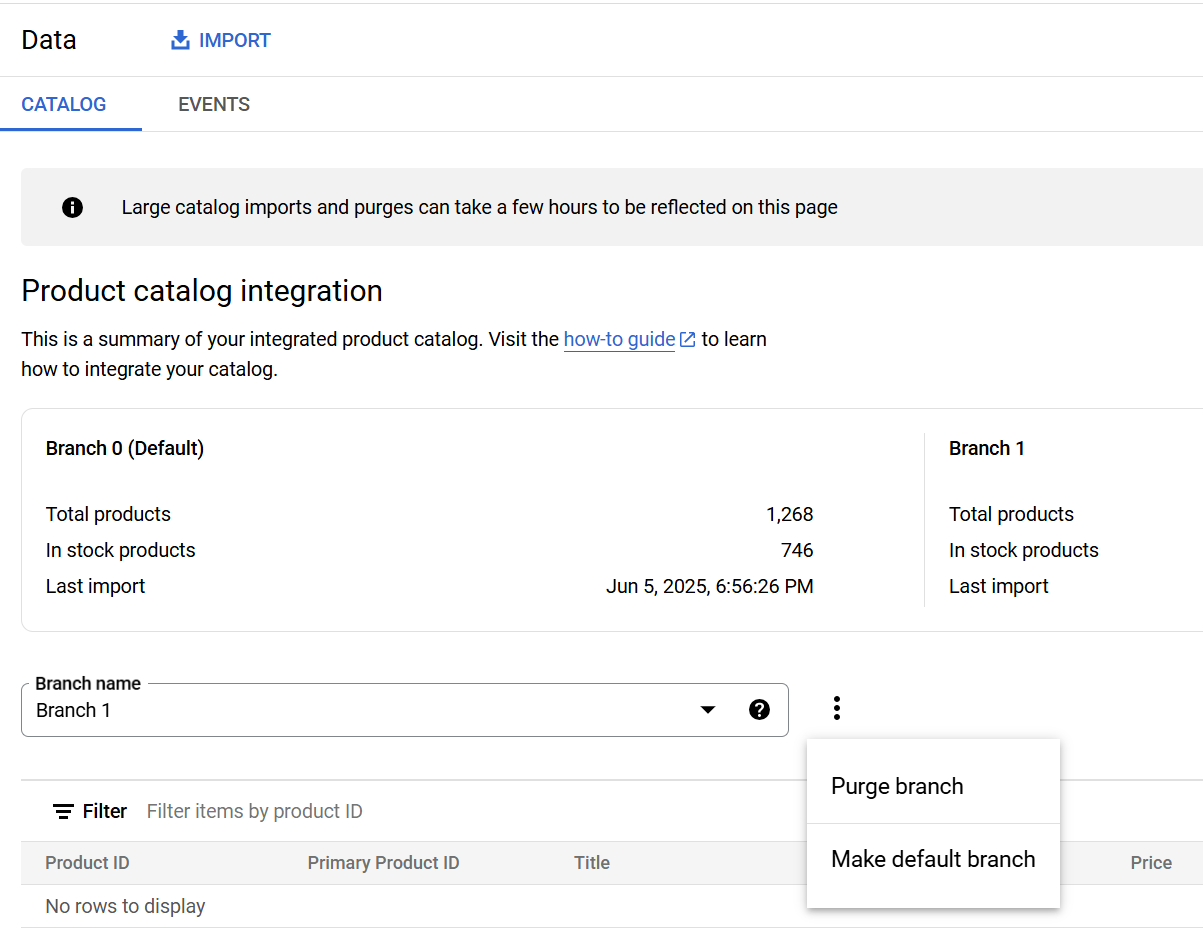

> **⚠️ It may take 2-5 minutes for the background process to reload the catalog.** Wait till data is loaded into catalog (`Total Results` will be non-zero value). If you still see limited output, purge the catalog again and wait a few minutes.

In [1]:
response = search_client.search(request)
print(f"Total Results: {response.total_size}:")
for result in response.results:
  print(result)

NameError: name 'search_client' is not defined

# Advanced search configurations
The Retail API supports advanced search configurations, allowing you to customize how search results are generated. This includes setting up custom ranking expressions, filtering, and faceting options. We'll explore these configurations in detail in this lab.

First, let's define a function to create a search request with advanced configurations. This function will allow us to specify custom ranking expressions, filters, and facets for our search queries.

In [ ]:
def get_search_request(
    query: str,
    *,
    facet_key_param: str = None,
    query_expansion_condition=None,
    page_size: int = 5,
    offset: int = None,
    next_page_token: str = None,
    order: str = None,
    _filter: str = None,
    boost_condition: str = None,
    boost_strength: float = None,
    visitor_id: str = "123456"
):
    """
    Builds and returns a SearchRequest object for the Retail API, supporting facets, query expansion, pagination, ordering, filtering, and boosting.
    Uses global variables DEFAULT_SEARCH and project_id if not provided.
    Only configures aspects for which parameters are provided.
    """

    # --- Placement and basic fields ---
    placement = DEFAULT_SEARCH
    search_request = SearchRequest()
    search_request.placement = placement
    search_request.query = query
    search_request.visitor_id = visitor_id
    search_request.page_size = page_size
    search_request.branch = DEFAULT_BRANCH

    # --- Facet configuration ---
    if facet_key_param:
        facet_key = SearchRequest.FacetSpec.FacetKey(key=facet_key_param)
        facet_spec = SearchRequest.FacetSpec(facet_key=facet_key)
        search_request.facet_specs = [facet_spec]

    # --- Query Expansion configuration ---
    if query_expansion_condition is not None:
        query_expansion_spec = SearchRequest.QueryExpansionSpec(condition=query_expansion_condition)
        search_request.query_expansion_spec = query_expansion_spec

    # --- Pagination configuration ---
    if offset is not None:
        search_request.offset = offset
    if next_page_token:
        search_request.page_token = next_page_token

    # --- Ordering configuration ---
    if order:
        search_request.order_by = order

    # --- Filtering configuration ---
    if _filter:
        search_request.filter = _filter

    # --- Boosting configuration ---
    if boost_condition and boost_strength is not None:
        condition_boost_spec = SearchRequest.BoostSpec.ConditionBoostSpec(
            condition=boost_condition, boost=boost_strength
        )
        boost_spec = SearchRequest.BoostSpec(condition_boost_specs=[condition_boost_spec])
        search_request.boost_spec = boost_spec

    # --- Debug printout ---
    print("---search request---")
    print(search_request)
    return search_request

### 1. Simple Search Query
This is the most basic use case: searching for products using a free-text query. Use this when you want to retrieve products matching a user's search phrase, without any advanced filtering or configuration.

In [ ]:
search_client = SearchServiceClient()
request = get_search_request(query="Hoodie")
response = search_client.search(request)


In [ ]:
print_search_results(response)

In [ ]:
display(json2df(response.results))

### 2. Faceted Search
Faceted search allows you to group and filter results by product attributes (facets), such as color, brand, or price range. This is useful for building e-commerce experiences where users can refine results using filters.

Faceted search is configured by specifying one or more facet keys in your search request using the `facet_specs` parameter. Each facet key corresponds to a product attribute (such as `colorFamilies`, `brands`, or `price`) that you want to group results by. The Retail API will return facet buckets for each specified attribute, allowing you to display filter options in your UI.

**How to configure faceted search:**
- In your search request, set the `facet_specs` field with one or more `FacetSpec.FacetKey` objects, each specifying the attribute to facet on.
- Example: To facet by color family, use `facet_key_param="colorFamilies"` in your search request builder.

**Rules and conditions for faceted search:**
- Only attributes marked as **indexable** and **dynamic facetable** in your catalog configuration can be used as facets.
- Faceting works best with categorical/text attributes (e.g., color, brand, size). Numerical attributes (like price) can be faceted using value buckets.
- You can specify multiple facet keys to enable multi-faceted filtering (e.g., color and brand).
- The API returns facet values and counts for each facet key, which you can use to build filter menus.
- Facet values are case-sensitive and must match the attribute values in your catalog.
- If you request a facet on a non-indexable or non-facetable attribute, the API will return an error.

**Best practices:**
- Only facet on attributes that are relevant for user filtering and have a manageable number of unique values.
- Avoid faceting on attributes with too many unique values (e.g., product IDs), as this can degrade performance and user experience.
- Use the facet results to dynamically build filter UIs, allowing users to refine their search interactively.

**Example user flow for faceted search:**

1. The user searches for "Hoodie" and sees a list of hoodie products.
2. The UI displays available facet options (e.g., colorFamilies, brands, sizes) based on the returned facets from the Retail API.
3. The user selects "Black" under the color facet and "Google" under the brand facet.
4. The application sends a new search request with the selected facets as filters (e.g., `colorFamilies: ANY("Black") AND brands: ANY("Google")`).
5. The results update to show only black hoodies from the Google brand.
6. The user can further refine results by selecting additional facets, and the UI updates dynamically based on the new facet selections.

This interactive faceted search experience helps users quickly narrow down results to products that match their preferences.

For more details, see the [Retail API documentation on faceting](https://cloud.google.com/retail/docs/filter-and-order#facets).

In [ ]:
request = get_search_request(query="Hoodie", facet_key_param="colorFamilies")
response = search_client.search(request)


In [ ]:
print("Facet results: (JSON)")
for facet in response.facets:
    print(facet)


In [ ]:

print("Facet results: (DataFrame)")
# Retrieve the colorFamilies facet from response.facets
color_families_facet = next((f for f in response.facets if f.key == "colorFamilies"), None)
if color_families_facet:
    df = pd.DataFrame([{"value": v.value, "count": v.count} for v in color_families_facet.values])
    display(df)
else:
    print("colorFamilies facet not found.")

You can test this query in Google Cloud Console as well.

* Navigate to Evaluate -> Search (https://console.cloud.google.com/ai/retail/catalogs/default_catalog/evaluate/search)
* Select 'Branch 1' from the dropdown.
* Enter the query `Hoodie` and click `Search Preview`

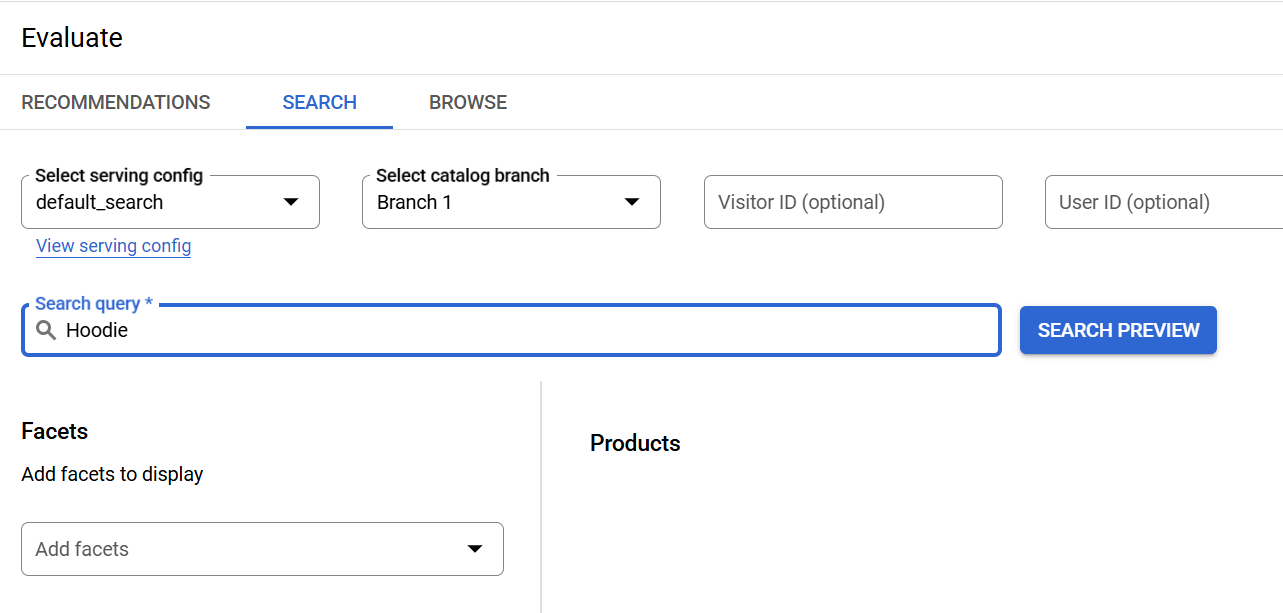

After running the query, you should see results that include products with the term "Hoodie" in their name or description. Click `Add Facet` and select `colorFamilies`.

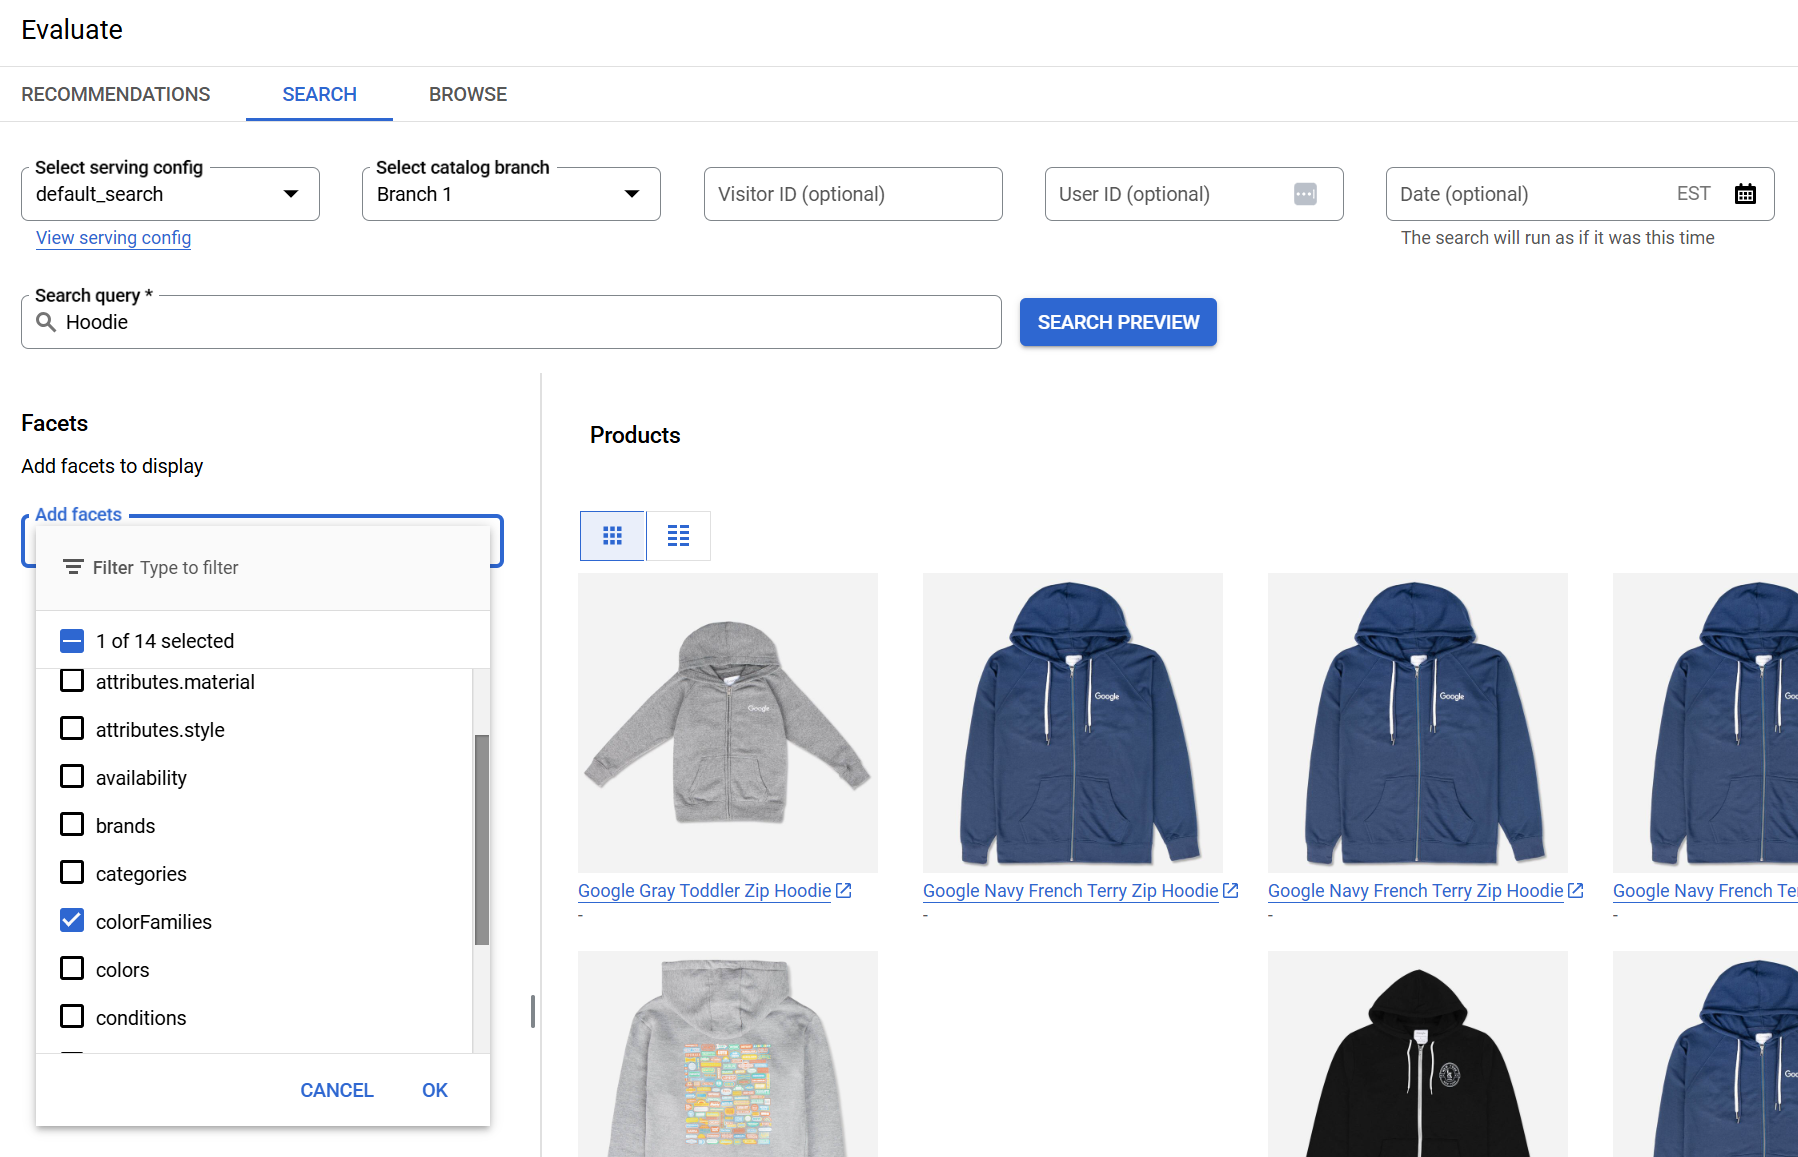

You will see the facets retrieved from the search results. In production systems, you would typically use these facets to build a filter UI for users to refine their search results.

## 3. Query Expansion
Query expansion automatically enhances user queries by adding synonyms or related terms. This improves recall by matching products that may not have the exact search terms but are still relevant.

**How query expansion works:**
- When enabled, the Retail API analyzes the original query and may expand it with synonyms, alternate spellings, or related concepts based on Google’s knowledge graph and historical search data.
- Expanded queries can increase recall, returning more products that are relevant but may not contain the exact search terms.

**Configuration options:**
- Query expansion is controlled via the `query_expansion_spec` field in the search request.
- You can set the `condition` to:
  - `AUTO`: The API decides when to expand the query.
  - `DISABLED`: Query expansion is turned off (default).
  - `ALWAYS`: Always expand the query (rarely used; not recommended for most use cases).

**Constraints and rules:**
- Query expansion only applies to text-based queries.
- It works best when your catalog attributes (e.g., `title`, `description`, `brands`) are marked as **searchable** in the attribute configuration.
- Not all queries will be expanded; the API uses internal logic to determine when expansion is beneficial.
- Query expansion does not override filters or facets—results must still match all filter conditions.
- Overuse of expansion may reduce precision, so use it judiciously and monitor user experience.

**Best practices:**
- Enable query expansion for broad, ambiguous, or misspelled queries to improve recall.
- For highly specific or technical queries, consider disabling expansion to maintain precision.
- Always test query expansion with your own catalog and user queries to ensure it improves search quality.

**Example user flow for query expansion:**

1. The user enters a search query that may be ambiguous, misspelled, or too specific (e.g., "Sweatshirt Hoodie Google Blue").
2. The application sends a search request to the Retail API with query expansion disabled. Only products that exactly match the query terms are returned.
3. The user sees a limited set of results, possibly missing relevant products due to strict matching.
4. The application enables query expansion by setting `query_expansion_spec.condition = AUTO` in the search request.
5. The Retail API analyzes the query and automatically expands it with synonyms or related terms (e.g., "Sweatshirt" may match "Pullover", "Hoodie" may match "Jacket").
6. The user now sees a broader set of relevant products, including those that do not contain the exact original search terms but are still a good match.
7. The application can compare results with and without query expansion to evaluate the impact on recall and relevance.
8. Based on user engagement and business goals, the application can decide when to enable or disable query expansion for different types of queries.

For more details, see the [Retail API documentation on query expansion](https://cloud.google.com/retail/docs/query-expansion).



Let's run a query without query expansion first.

In [ ]:
from google.cloud.retail_v2.types import SearchRequest

# Define the search query
query = "Sweatshirt Hoodie Google Blue"

# Perform search without query expansion
response1 = search_client.search(get_search_request(
  query=query,
  page_size=15
))

print(f"---Total results found: {response1.total_size}---")


Now, let's enable query expansion and run the same query again. This will allow us to see how the results change when the Retail API automatically expands the search terms.

In [ ]:

request = get_search_request(
  query="Sweatshirt Hoodie Google Blue",
  query_expansion_condition=SearchRequest.QueryExpansionSpec.Condition.AUTO,
  page_size=15
)
response2 = search_client.search(request)

print(f"---Total results found: {response2.total_size}---")


Now that we executed two queries, let's compare the results. The first query without query expansion should return a limited set of products that match the exact search terms. The second query with query expansion should return a broader set of products, including those that match synonyms or related terms.

In [ ]:

# Print and compare the total number of results for both searches
print(f"---Total results: '{response1.total_size}' vs '{response2.total_size}'---")

# Helper function to extract IDs and Titles from a Retail API response
def extract_id_title(response):
  data = []
  for result in response.results:
    prod_id = getattr(result, "id", None)
    title = None
    # Try to get title if available
    if hasattr(result, "product") and hasattr(result.product, "title"):
      title = result.product.title
    data.append({"id": prod_id, "title": title})
  return pd.DataFrame(data)

df1 = extract_id_title(response1)
df2 = extract_id_title(response2)

# Outer join on 'id'
comparison = pd.merge(df1, df2, on="id", how="outer", suffixes=('_no_expansion', '_expansion'))
display(comparison)




## 4. Pagination
Pagination allows you to control the number of results returned in a single search response. This is useful for displaying search results in pages, improving user experience and performance.

There are two main ways to paginate through Retail API search results:

1. **Offset-based pagination:**  
  You specify the `offset` parameter in your search request to skip a certain number of results. For example, if your first page uses `offset=0` and `page_size=5`, the next page would use `offset=5` and `page_size=5`. This approach is simple but can be less efficient for large result sets.

2. **Token-based pagination:**  
  The API returns a `next_page_token` in the response. To get the next page, include this token in your next search request using the `page_token` parameter. This method is recommended for consistency and performance, especially when dealing with dynamic or frequently changing data.

---

In the example below, we will demonstrate both offset-based and token-based pagination:
- Run a search query and print the first page of results.
- Retrieve the next page using both offset-based and token-based pagination.
- Print the results for each approach to compare their outputs.

In [ ]:
request = get_search_request(query="Hoodie", page_size=5, offset=0)
response = search_client.search(request)

# Select only the specified fields in each DataFrame
fields = [
    "id",
    "product.categories",
    "product.title",
    "product.attributes.material.text",
    "product.attributes.style.text",
    "product.availability",
    "product.color_info.color_families",
    "product.color_info.colors",
    "product.sizes"
]

def select_fields(df):
    # Some columns may not exist in all results, so use intersection
    cols = [col for col in fields if col in df.columns]
    return df[cols]

print("First page of results (selected fields):")
display(select_fields(json2df(response.results)))

# Using offset (for offset-based pagination)
request_next_offset = get_search_request(query="Hoodie", page_size=5, offset=5)
response_next_offset = search_client.search(request_next_offset)
print("\nSecond page of results (using offset, selected fields):")
display(select_fields(json2df(response_next_offset.results)))

# Using next_page_token (for token-based pagination)
if response.next_page_token:
    request_next_token = get_search_request(query="Hoodie", page_size=5, next_page_token=response.next_page_token)
    response_next_token = search_client.search(request_next_token)
    print("\nSecond page of results (using next_page_token, selected fields):")
    display(select_fields(json2df(response_next_token.results)))
else:
    print("\nNo next_page_token available.")


## 5. Ordering Results
Ordering allows you to sort results by specific product fields, such as price or rating. This is useful for letting users sort by "price low to high", "best sellers", etc. Without specifying an order, results are ordered by relevance, which is determined by the Retail API's internal ranking logic.

The `order` parameter in Retail API search requests allows you to specify how results should be sorted. The value is a string that defines one or more fields to sort by, separated by commas. Each field can be optionally followed `desc` (descending).

> **Note:** if `desc` is not specified, the default sort direction is ascending (`asc`). **You cannot use `asc` explicitly**; it is implied if no direction is specified.

**Rules and considerations:**

- Only attributes marked as **indexable** can be used for ordering.
- If you reference an attribute that does not exist or is not indexable, the API will return an error.
- If no direction is specified, the default is ascending (`asc`).
- You can combine multiple fields: `price desc, rating`.
- Not all fields are supported for ordering (e.g., text fields like `description` are not valid).

You can find more information about the supported fields and their indexable status in the [Retail API documentation](https://cloud.google.com/retail/docs/filter-and-order#order).

**Example usage:**

- To sort by price descending: `order="price desc"`
- To sort by rating ascending: `order="rating"`
- To sort by multiple fields: `order="price desc, rating desc"`

If you specify an invalid field or direction, the API will raise an error indicating the issue. Always verify attribute names and their indexable status before using them in the `order` parameter.

**Example scenario:**  
Suppose you are building an e-commerce site and want to let users sort hoodie search results by price (low to high) or by rating (high to low):

1. The user searches for "Hoodie".
2. The UI displays a "Sort by" dropdown with options like "Price: Low to High" and "Rating: High to Low".
3. When the user selects "Price: Low to High", your application sends a search request with `order="price"`.
4. When the user selects "Rating: High to Low", your application sends a search request with `order="rating desc"`.
5. The Retail API returns results sorted as requested, and your UI displays them accordingly.

This control enables a dynamic, user-driven sorting experience, improving product discovery and user satisfaction.

In [ ]:
fields = [
    "id",
    "product.title",
    "product.priceInfo.price"
]

request = get_search_request(query="Hoodie", page_size=10)
response = search_client.search(request)
df = json2df(response.results)

request2 = get_search_request(query="Hoodie", page_size=10, order="price desc, title")
response2 = search_client.search(request2)
df2 = json2df(response2.results)

# Display both DataFrames side-by-side
html = f"""
<div style='display: flex; gap: 40px;'>
    <div>
        <h4>without sorting</h4>
        {df[fields].to_html(index=False)}
    </div>
    <div>
        <h4>with sorting</h4>
        {df2[fields].to_html(index=False)}
    </div>
</div>
"""
display_html(html, raw=True)

## 6. Filtering Results
Filtering lets you restrict results to products matching certain criteria, such as color, brand, or price range. This is useful for narrowing down results to only those relevant to the user's preferences.

Filtering in the Retail API allows you to refine search results based on specific product attributes. You can use filters to include or exclude products that match certain criteria, such as color, brand, or price range.

To apply a filter in the Retail API, use the `_filter` parameter in your search request. The filter expression specifies which products to include based on attribute values. You can filter on any attribute that is marked as **indexable** in your catalog configuration.

**Filter syntax examples:**

- **Set membership:** `colorFamilies: ANY("Black", "Gray")`
- **Numerical comparison:** `price: IN(*, 30e)`
- **Multiple conditions:** `colorFamilies: ANY("Black") AND price: IN(*, 50e)`
- **String contains:** `title: "Hoodie"`

**Rules and constraints:**

- Only **indexable** attributes can be used in filters. Check your catalog configuration to confirm which fields are indexable.
- String values must be enclosed in double quotes.
- Use `AND`, `OR`, and parentheses to combine multiple conditions.
- For array attributes (like `colorFamilies`), use `ANY()` to match any value in the list.
- Numerical comparisons (`>`, `<`, `>=`, `<=`) are supported for numerical attributes.
- Filtering on custom attributes is supported if they are indexable.
- Invalid filters or use of non-indexable fields will result in an API error.

**Example:**

To filter for black hoodies under $50:

`_filter='colorFamilies: (ANY("Black") AND price: IN(*, 50e))'`

For more details, see the [Retail API filter documentation](https://cloud.google.com/retail/docs/filter-and-order#filter).

**Example user flow for filtering:**

1. The user searches for "Hoodie" and sees a list of all hoodie products.
2. The UI displays available filter options (facets), such as color, brand, or size, based on the returned facets (e.g., `colorFamilies` with values like "Black", "Gray", "Navy").
3. The user selects "Black" from the color filter.
4. The application sends a new search request with the filter applied: `_filter='colorFamilies: ANY("Black")'`.
5. The results update to show only hoodies where "Black" is one of the color families.

For more information on the filter syntax and available fields, refer to the [Retail API documentation](https://cloud.google.com/retail/docs/filter-and-order#filter).

This interactive filtering experience helps users quickly narrow down results to products that match their preferences.


In [ ]:
fields= [
    "id",
    "product.title",
    "product.colorInfo.colorFamilies",
    "product.colorInfo.colors",
]

request = get_search_request(query="Hoodie", page_size=10)
df = json2df(search_client.search(request))[fields]
print("Search results without filter:")
display(df)

request = get_search_request(query="Hoodie", page_size=10, _filter='colorFamilies: ANY("Black")')
df = json2df(search_client.search(request))[fields]
print("Search results with filter:")
display(df)

## 7. Boosting Results
Boosting allows you to promote or demote products that match certain conditions, such as boosting products on sale or with high ratings. This is useful for business rules or merchandising strategies.

Boosting can be set as part of search request or as a ServingConfig configuration. If both are set, the boost conditions from both places are evaluated. If a search request matches multiple boost conditions, the final boost score is equal to the sum of the boost scores from all matched boost conditions.

**How boosting works:**
- You specify a `condition` (a filter expression) and a `boost` value.
- The `boost` value must be between -1.0 and 1.0 (exclusive). Values greater than 0 promote, values less than 0 demote, and 0 means no effect.
- Products matching the condition are boosted or demoted in the search results.
- Multiple boost conditions can be combined for complex strategies.

**Applicable fields:**  
Boosting can be applied to any attribute that is **indexable** in your catalog configuration. Common examples include:
- `availability` (e.g., boost in-stock items)
- `price` (e.g., boost discounted products)
- `brands`, `categories`, or custom attributes

**Syntax:**
- The `condition` uses the same filter syntax as the `_filter` parameter (see Filtering Results section).
- The `boost` is a float between -1.0 and 1.0 (exclusive).

**Examples:**
- Boost in-stock products:  
  `boost_condition='availability: ANY("IN_STOCK")', boost_strength=0.5`
- Demote out-of-stock products:  
  `boost_condition='availability: ANY("OUT_OF_STOCK")', boost_strength=-0.5`
- Boost products under $30:  
  `boost_condition='price: IN(*, 30e)', boost_strength=0.3`
- Boost a specific brand:  
  `boost_condition='brands: ANY("Google")', boost_strength=0.7`

**Best practices:**
- Use boosting for business-driven ranking, not for filtering (boosted items still must match the main query).
- Avoid excessive boosting, which can override relevance and degrade user experience.
- Only use indexable fields in boost conditions.

For more details, see the [Retail API documentation on boosting](https://cloud.google.com/retail/docs/boosting).

In [ ]:
fields= [
    "id",
    "product.title",
    "product.availability"
]

request = get_search_request(query="Hoodie", page_size=30)
df = json2df(search_client.search(request))[fields]
print("Search results without boosting:")
display(df)

request = get_search_request(query="Hoodie", boost_condition='availability: ANY("IN_STOCK")', boost_strength=1.0)
df = json2df(search_client.search(request))[fields]
print("Search results with positive boosting:")
display(df)
